In [1]:
# Importing cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import nbinom 
import warnings
import statsmodels as st
from statsmodels.discrete.discrete_model import NegativeBinomial


warnings.filterwarnings("ignore")

-----------------------------

# Physical Models of Living Systems

#### *Rafaele Gaudio 2057974*
#### *Marco Lorenzetti  2056112*

-----------------------------

## Week 2: - Deadline 27 October 

Infer the number of species from data of a forest sampled in 1% of the total area.

Each row represent a different species, and the number indicates the species abundance (i.e., the number of individuals). 

-----------------------------

## 1. Inference of total nuber of speces

The probability of finding $k$ individuals of a species at given scale $p$ of our forest is given by:

$$
P^*_p(k) \propto {k+\tilde{r}_p-1 \choose k}\tilde{\xi}^k_p=c \mathtt{NBinom}(\tilde{r}_p,\tilde{\xi}_p) \quad c=\text{const.}
$$

Since the probability of finding $k$ individuals of a species at scale 1 is also a $\mathtt{NBinom}(r,\xi)$, we can link $\tilde{r}_p$ and $\tilde{\xi}_p$ to $r$ and $\xi$ by the self-similarity property of the negative binomial distribution:

$$
\tilde{r}_p=r \quad \tilde{\xi}_p= \frac{p \xi}{1-\xi(1-p)}
$$

In this way, knowing $\tilde{r}_p$ and $\tilde{\xi}_p$ from the data, we can infer the total number of species at scale 1 as:

$$
S=S^{(p)}\frac{1-(1-\xi)^r}{1-(1-\tilde{\xi}_p)^r}
$$

where $S^{(p)}$ is the number of species at scale $p$.

Number of species in the sample: 4283


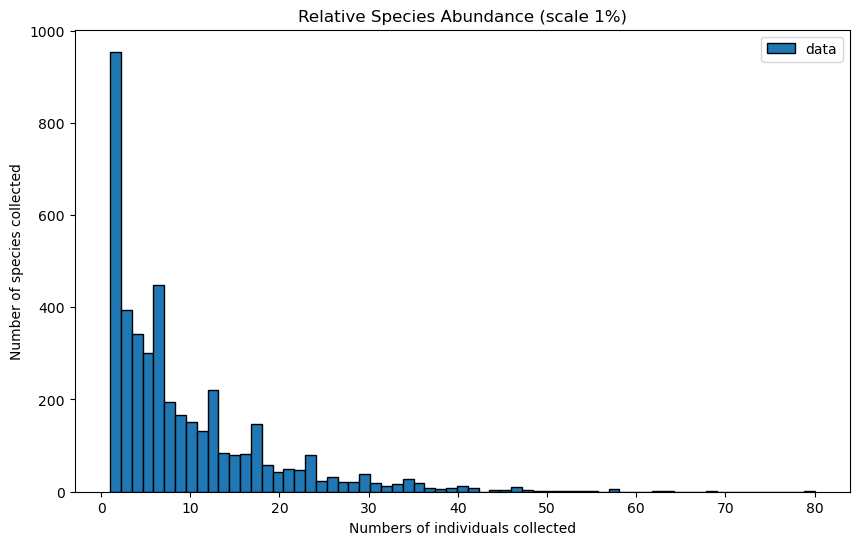

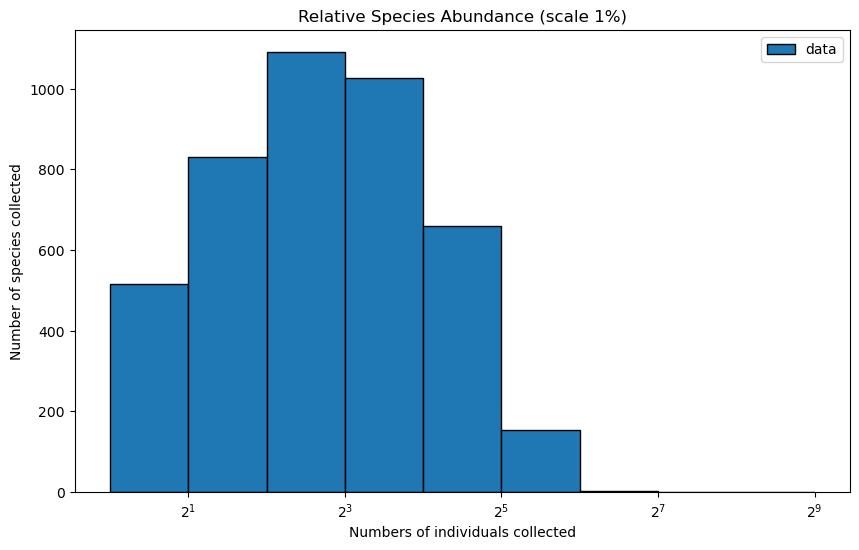

In [2]:
df=pd.read_csv("RSA_sampled_1percent.csv",sep=";",header=None)
data={"Abundance":df[0]}

df=pd.DataFrame(data)

M=len(df["Abundance"])
print("Number of species in the sample:",M)

bins=int(np.sqrt(len(df["Abundance"])))

log_bins=[]
for k in range(10):
    log_bins.append(2**k)

fig, ax=plt.subplots(figsize=(10,6))
ax.hist(df["Abundance"],bins=bins,edgecolor="black",label="data")
ax.set(xlabel="Numbers of individuals collected",ylabel="Number of species collected",title="Relative Species Abundance (scale 1%)")
ax.legend();

fig, ax=plt.subplots(figsize=(10,6))
ax.set_xscale("log",base=2)
ax.hist(df["Abundance"],bins=log_bins,edgecolor="black",label="data")
ax.set(xlabel="Numbers of individuals collected",ylabel="Number of species collected",title="Relative Species Abundance (scale 1%)")
ax.legend();

### 1.1. Infer the total number of species (approximated)

Our first attempt is try to reconstruct the parameters of the $\mathtt{Nbinom}(\tilde{r}_p,\tilde{\xi}_p)$ from the data as:

$$
\tilde{r}_p=\frac{\mu^2}{\sigma^2-\mu} \quad \tilde{\xi}_p=\frac{\mu}{\sigma^2} 
$$

where $\mu$ is the mean and $\sigma^2$ is the variance of the data.

Parameters of the NBinom at scale 0.1: 
 xi: 0.10915832962520716 
 r: 1.138052100278662 



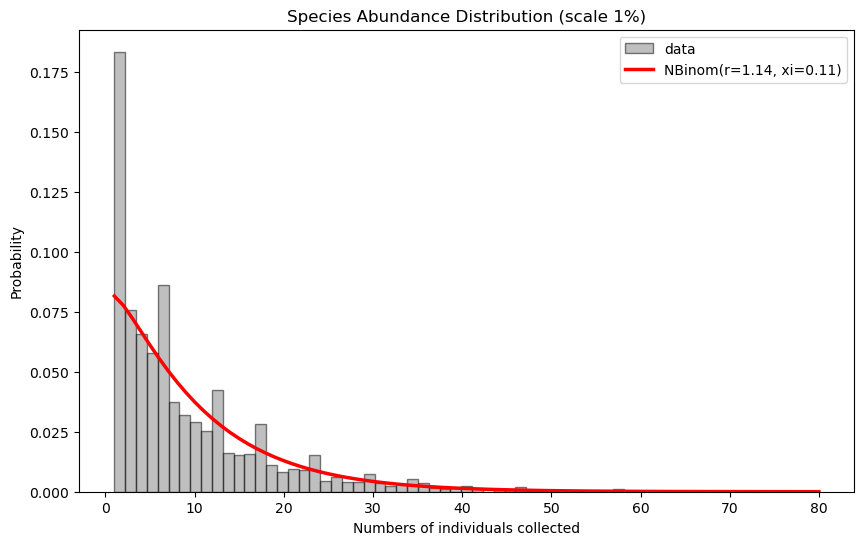

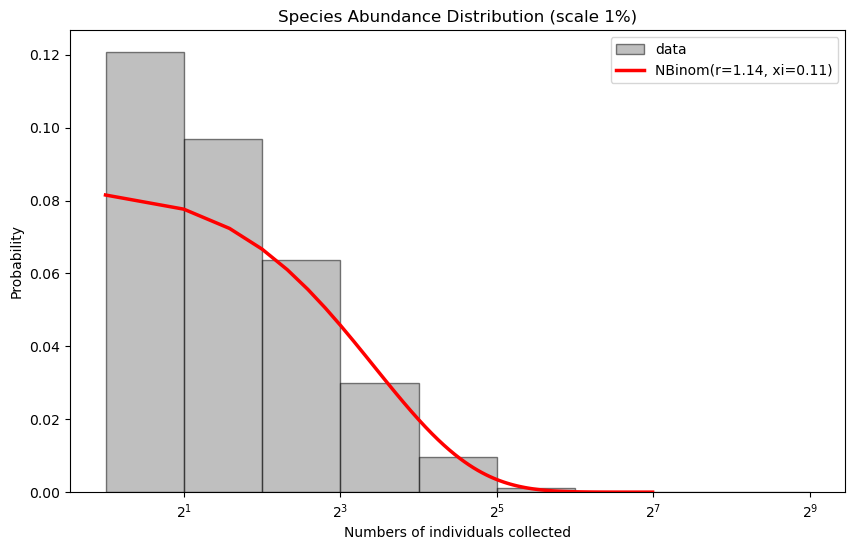

In [3]:
mean_data=np.mean(df["Abundance"])
var_data=np.var(df["Abundance"])

p=mean_data/var_data
n=mean_data**2/(var_data-mean_data)

x1 = range(1,81)
x = range(1,2**7)

fig, ax=plt.subplots(figsize=(10,6))
ax.set(xlabel="Numbers of individuals collected",ylabel="Probability",title="Species Abundance Distribution (scale 1%)")
ax.hist(df["Abundance"],bins=bins,edgecolor="black",color="gray",label="data",density=True, alpha=0.5)
ax.plot(x1,nbinom.pmf(x1,n,p),color="red",linewidth=2.5,label="NBinom(r={:.2f}, xi={:.2f})".format(n,p))
ax.legend();

fig, ax=plt.subplots(figsize=(10,6))
ax.set_xscale("log",base=2)
ax.set(xlabel="Numbers of individuals collected",ylabel="Probability",title="Species Abundance Distribution (scale 1%)")
ax.hist(df["Abundance"],bins=log_bins,edgecolor="black",color="gray",label="data",density=True, alpha=0.5)
ax.plot(x,nbinom.pmf(x,n,p),color="red",linewidth=2.5,label="NBinom(r={:.2f}, xi={:.2f})".format(n,p))
ax.legend();

print("Parameters of the NBinom at scale 0.1: \n xi:",p,"\n r:",n,"\n")

In [4]:
scale=0.1

xi=p/(scale+p*(1-scale))
r=n

S=M*(1-(1-xi)**r)/(1-(1-p)**r)

print("Parameters of the NBinom at scale 1: \n xi:",xi,"\n r:",r,"\n")
print("Total number of species estimated at scale 1:",int(S))


Parameters of the NBinom at scale 1: 
 xi: 0.5506303212622581 
 r: 1.138052100278662 

Total number of species estimated at scale 1: 20765


### 1.2. Infer the total number of species via scipy fitting

Our second attempt is obtain the negative binomial parameters directly from fitting using the module $\mathtt{statsmodels}$.

In [5]:
X = np.ones_like(df['Abundance'])
res = NegativeBinomial(df['Abundance'], X).fit(start_params=[1,1])

Optimization terminated successfully.
         Current function value: 3.257850
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9


Parameters of the NBinom at scale 0.1: 
 xi: 0.130774177366895 
 r: 1.3973167929170622 



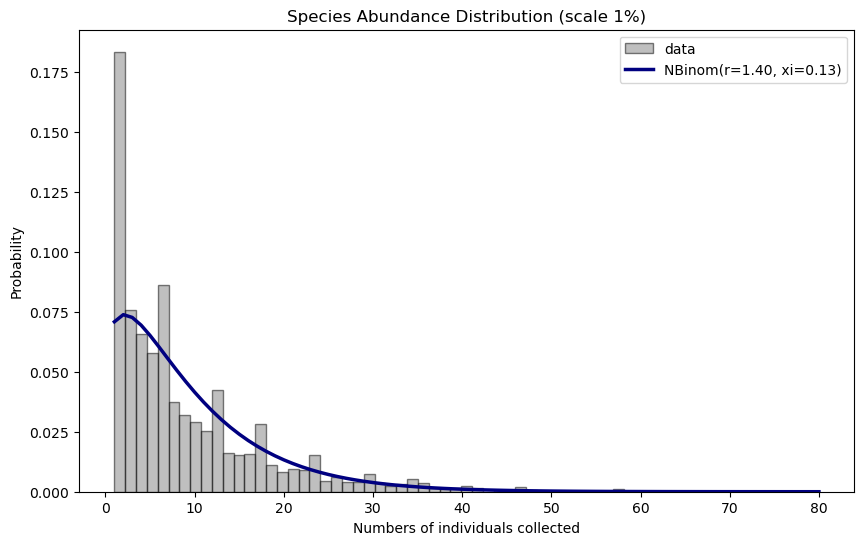

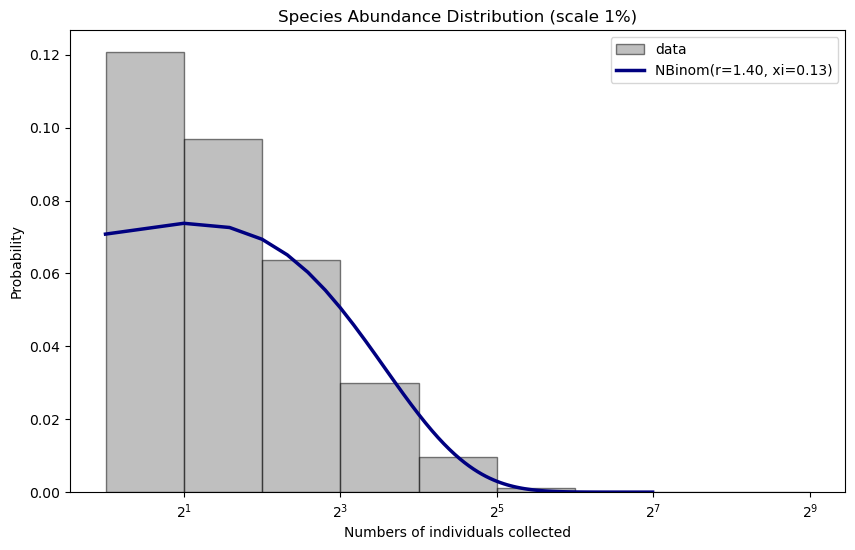

In [6]:
mu_fit = np.exp(res.params[0])
p_fit = 1/(1 + mu_fit*res.params[1])
n_fit = mu_fit*p_fit/(1 - p_fit)

fig, ax=plt.subplots(figsize=(10,6))
ax.set(xlabel="Numbers of individuals collected",ylabel="Probability",title="Species Abundance Distribution (scale 1%)")
ax.hist(df["Abundance"],bins=bins,edgecolor="black",color="gray",label="data",density=True, alpha=0.5)
ax.plot(x1,nbinom.pmf(x1, n_fit, p_fit),color="navy",linewidth=2.5,  label="NBinom(r={:.2f}, xi={:.2f})".format(n_fit,p_fit))
ax.legend();

fig, ax=plt.subplots(figsize=(10,6))
ax.set_xscale("log",base=2)
ax.set(xlabel="Numbers of individuals collected",ylabel="Probability",title="Species Abundance Distribution (scale 1%)")
ax.hist(df["Abundance"],bins=log_bins,edgecolor="black",color="gray",label="data",density=True, alpha=0.5)
ax.plot(x,nbinom.pmf(x, n_fit, p_fit),color="navy",linewidth=2.5,  label="NBinom(r={:.2f}, xi={:.2f})".format(n_fit,p_fit))
ax.legend();

print("Parameters of the NBinom at scale 0.1: \n xi:",p_fit,"\n r:",n_fit,"\n")

In [7]:
xi_fit=p_fit/(scale+p_fit*(1-scale))
r_fit=n_fit

S_fit=M*(1-(1-xi_fit)**r_fit)/(1-(1-p_fit)**r_fit)

print("Parameters of the NBinom at scale 1: \n xi:",xi_fit,"\n r:",r_fit,"\n")
print("Total number of species estimated at scale 1:",int(S_fit))


Parameters of the NBinom at scale 1: 
 xi: 0.6007171516426653 
 r: 1.3973167929170622 

Total number of species estimated at scale 1: 17405
